In [ ]:
!pip install pyttsx3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pytelegrambotapi


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.0/232.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytelegrambotapi: filename=pyTelegramBotAPI-4.12.0-py3-none-any.whl size=213956 sha256=732261717ca3bd14ec4d5d172e205eead3975f10ee395ffeca9a2df7654333f6
  Stored in directory: /root/.cache/pip/wheels/7e/ba/82/f3ab5bc48525778633bccc741c0424677ed3435736221819f4
Successfully built pytelegrambotapi


In [10]:
import telebot
import string
import pickle
import re
import csv
import pandas as pd
import numpy as np
import smtplib
import ssl
from email.message import EmailMessage




bot = telebot.TeleBot("6143785395:AAGNRjBthhXk9MZrwjSc1R2LjAKmpLXgH6s")

# Create a dictionary to store the chat log for each user
chat_logs = {}


training = pd.read_csv('Training.csv')

reduced_data = training.groupby(training['prognosis']).max()

le = None
le2 = None
model, model2 = None, None

#load le from saved pickle after training
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

with open('label_encoder2.pkl', 'rb') as f:
    le2 = pickle.load(f)

with open('model1.pkl', 'rb') as f:
    model = pickle.load(f)

with open('model2.pkl', 'rb') as f:
    model2 = pickle.load(f)

symptomsDict = {symptom: index for index, symptom in enumerate(model.feature_names_in_)}
description_list = dict()

#initialize descriptions list
with open('symptom_Description.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        _description={row[0]:row[1]}
        description_list.update(_description)


states = dict() #store current user text
store = dict() #atore user answer
# symptoms = dict() #store symptoms list for user


FINAL = 6

def check_pattern(dis_list, _input):
    _input = _input.replace(' ', '_')

    pattern = f"{_input}"
    regexp = re.compile(pattern)

    pred_list = [item for item in dis_list if regexp.search(item)]
    return pred_list

def predict_from_symptoms(symptoms, use_other_model=False):
    inputVector = np.zeros(len(model.feature_names_in_)) #empty vector to be infilled
    for s in symptoms:
        inputVector[[symptomsDict[s]]] = 1 #fill symptoms vector
    # print(syptom_df)

    if not use_other_model:
      symptom_pred = model.predict([inputVector])
      disease = le.inverse_transform(symptom_pred)
      return disease

    else:
      symptom_pred = model2.predict([inputVector])
      disease = le2.inverse_transform(symptom_pred)
      return disease



def preprocess(symptom, duration):
    # Convert symptom to lowercase and remove punctuation
    symptom = symptom.lower().strip().translate(str.maketrans('', '', string.punctuation))

    # Convert duration to days
    duration_days = duration

    # Create a one-hot encoding of the symptom
    symptoms = ["fever", "cough", "fatigue", "headache", "loss of smell or taste"]
    symptom_one_hot = [int(symptom == s) for s in symptoms]

    # Combine the symptom and duration information into a single list
    data = [symptom_one_hot + [duration_days]]

    return data

def send_email_with_chat_log(chat_log, diagnosis):
    email_sender = 'joshua.healthchatbot@gmail.com'
    email_password = 'vgjphuxoxavaadri'
    email_receiver = 'jjsam106@gmail.com'


    subject = 'Health Chatbot Medical Diagnosis'
    body = f"From all symptoms provided, it seems this patient may have {diagnosis}. Please look to the chat dialog below and contact the user for further treatment. \n\nChat Log:\n{chat_log}"

    em = EmailMessage()
    em['From'] = email_sender
    em['To'] = email_receiver
    em['Subject'] = subject
    em.set_content(body)

    context = ssl.create_default_context()

    with smtplib.SMTP_SSL('smtp.gmail.com', 465, context=context) as smtp:
        smtp.login(email_sender, email_password)
        smtp.sendmail(email_sender, email_receiver, em.as_string())





@bot.message_handler(commands=['start', 'help'])
def send_welcome(message):
    bot.register_next_step_handler(message, start_repl)
    bot.reply_to(message, "Hello, I'm Carl, your health assistant. What's your name?")


@bot.message_handler(func=lambda message: True)
def start_repl(message):
    _id = message.chat.id
    store[_id] = {}
    store[_id]["name"] = message.text

    # Initialize chat log entry for new chat ID
    if _id not in chat_logs:
        chat_logs[_id] = []

    # Add chat log entry
    chat_logs[_id].append(f"User Name: {message.text}")


    bot.register_next_step_handler(message, get_phone_number)
    bot.reply_to(message, f"Hello, {store[_id]['name']}. What's your phone number?")

def get_phone_number(message):
    _id = message.chat.id

    # Initialize chat log entry for new chat ID
    if _id not in chat_logs:
        chat_logs[_id] = []

    store[_id]["phone_number"] = message.text

    # Add chat log entry
    chat_logs[_id].append(f"User Phone No.: {message.text}")


    # Continue with the rest of the conversation
    bot.register_next_step_handler(message, get_symptoms)
    bot.reply_to(message, "Great! What symptoms are you experiencing?")

@bot.message_handler(func=lambda message: True)
def get_symptoms(message):
    _id = message.chat.id

    # Initialize chat log entry for new chat ID
    if _id not in chat_logs:
        chat_logs[_id] = []

    latest_response = message.text

    # Add chat log entry
    chat_logs[_id].append(f"User symptom: {message.text}")


    if not "symptoms" in store[_id].keys():
        store[_id]['symptoms'] = [] #initialize empty


    if latest_response == "done":
        #done with listing symptoms

        bot.register_next_step_handler(message, get_symptom_days)
        bot.reply_to(message, "How many days has this occured?")
        return

    if latest_response in symptomsDict.keys():
        store[_id]['symptoms'].append(latest_response)
        bot.register_next_step_handler(message, get_symptoms )
        bot.reply_to(message, "Thank you for sharing your symptom. If you have any more to share, please go ahead, else type 'done'.")
        return

    else:
        #try to find symptoms by matching
        pred_list = check_pattern(symptomsDict.keys(), latest_response)

        if pred_list:
            resp  = "Did you mean any of the following? Reply with the updated name"
            for idx, i in enumerate(pred_list):
                resp += f"\n {idx}) {i}" #add each matched symptom
            bot.register_next_step_handler(message, get_symptoms)
            bot.reply_to_(message, resp)
            return


        else:
            #symptom does not match anything
            bot.reply_to(message, "Sorry this symptom is not in our database. Try again.")
            bot.register_next_step_handler(message, get_symptoms)
            return

    # Add chat log entry
    chat_logs[_id].append(f"User: {message.text}")

@bot.message_handler(func=lambda message: True)
def get_symptom_days(message):
    _id = message.chat.id

    if message.text.isnumeric():
        print(store[_id]['symptoms'])
        store[_id]["duration"] = int(message.text)

        # Add user input to the chat log
        chat_logs[_id].append(f"Symptom Duration (days): {message.text}")


        bot.register_next_step_handler(message, get_other_symptoms)

        bot.reply_to(message, f"I'm going to ask you some follow up questions just respond with yes/no. Type 'okay' to proceed")
        chat_logs[_id].append(f"Chatbot: I'm going to ask you some follow up questions just respond with yes/no. Type 'okay' to proceed")
    else:
        bot.register_next_step_handler(message, get_symptom_days)
        bot.reply_to(message, f"Response was not a number. Try again.")




@bot.message_handler(func=lambda message: True)
def get_other_symptoms(message):
    _id = message.chat.id

    if not "symptoms_given" in store[_id].keys():
        symptoms = store[_id]["symptoms"]
        present_disease  = predict_from_symptoms(symptoms)

        red_cols = reduced_data.columns
        symptoms_given = red_cols[reduced_data.loc[present_disease].values[0].nonzero()]

        store[_id]['count'] = 0
        store[_id]["symptoms_given"] = symptoms_given

    if store[_id]['count'] >= len(store[_id]["symptoms_given"]):
        if message.text.lower() in ['yes', 'y']:
            store[_id]["symptoms"].append(store[_id]['symptoms_given'][-1]) #add last answer

        bot.reply_to(message, "Done collecting symptoms. Type 'okay' to proceed.")
        bot.register_next_step_handler(message, get_prediction)
    else:
        cnt = store[_id]['count']
        if cnt > 0:
            if message.text.lower() in ['yes', 'y']:
                store[_id]["symptoms"].append(store[_id]['symptoms_given'][cnt]) #add symptom

        next_symptom = store[_id]["symptoms_given"][cnt]

        # Add the user input and bot response to the chat log
        chat_logs[_id].append(f"User: {message.text}")
        chat_logs[_id].append(f"Chatbot: {next_symptom} ?")

        bot.reply_to(message, f"{next_symptom} ? ")

        bot.register_next_step_handler(message, get_other_symptoms)
        store[_id]['count'] += 1
        return

@bot.message_handler(func=lambda message: True)
def get_prediction(message):
    _id = message.chat.id

    symptoms = store[_id]["symptoms"]

    pred1  = predict_from_symptoms(symptoms)[0]
    # pred2  = predict_from_symptoms(symptoms, True)[0]
    # print(pred1, pred2, description_list)
    # print(pred1, type(pred1), description_list, type(description_list))
    # resp = f"You may have {pred1} or {pred2}. \n {description_list[pred1]} \n {description_list[pred2]}. "
    resp = f"You may have {pred1}. \n {description_list[pred1]} \n Your Doctor has been notified of your condition and will contact you for further treatment. Until then please avoid self medication and remain calm. "

    # Add chat log entry
    if _id in chat_logs:
        chat_logs[_id].append(f"User: {message.text}")
        chat_logs[_id].append(f"Chatbot: {resp}")
    else:
        # Create a new chat log entry for the user
        chat_logs[_id] = [f"User: {message.text}", f"Chatbot: {resp}"]

    # Print the response
    bot.send_message(_id, resp)

    # Send the chat log via email
    send_email_with_chat_log('\n'.join(chat_logs[_id]), pred1)

    # Remove the chat log entry after sending the email
    del chat_logs[_id]


# def send_email_with_chat_log(chat_log, diagnosis):
#     email_sender = 'joshua.healthchatbot@gmail.com'
#     email_password = 'vgjphuxoxavaadri'
#     email_receiver = 'jjsam106@gmail.com'

#     subject = 'Health Chatbot Medical Diagnosis'
#     body = f"From all symptoms provided, it seems this patient may have {diagnosis}.\n\nChat Log:\n{chat_log}"

#     em = EmailMessage()
#     em['From'] = email_sender
#     em['To'] = email_receiver
#     em['Subject'] = subject
#     em.set_content(body)

#     context = ssl.create_default_context()

#     with smtplib.SMTP_SSL('smtp.gmail.com', 465, context=context) as smtp:
#         smtp.login(email_sender, email_password)
#         smtp.sendmail(email_sender, email_receiver, em.as_string())



bot.infinity_polling()




['headache']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
2023-06-21 22:10:10,522 (__init__.py:966 MainThread) ERROR - TeleBot: "Infinity polling: polling exited"
ERROR:TeleBot:Infinity polling: polling exited
2023-06-21 22:10:10,526 (__init__.py:968 MainThread) ERROR - TeleBot: "Break infinity polling"
ERROR:TeleBot:Break infinity polling


Decision tree plot saved as decision_tree.png


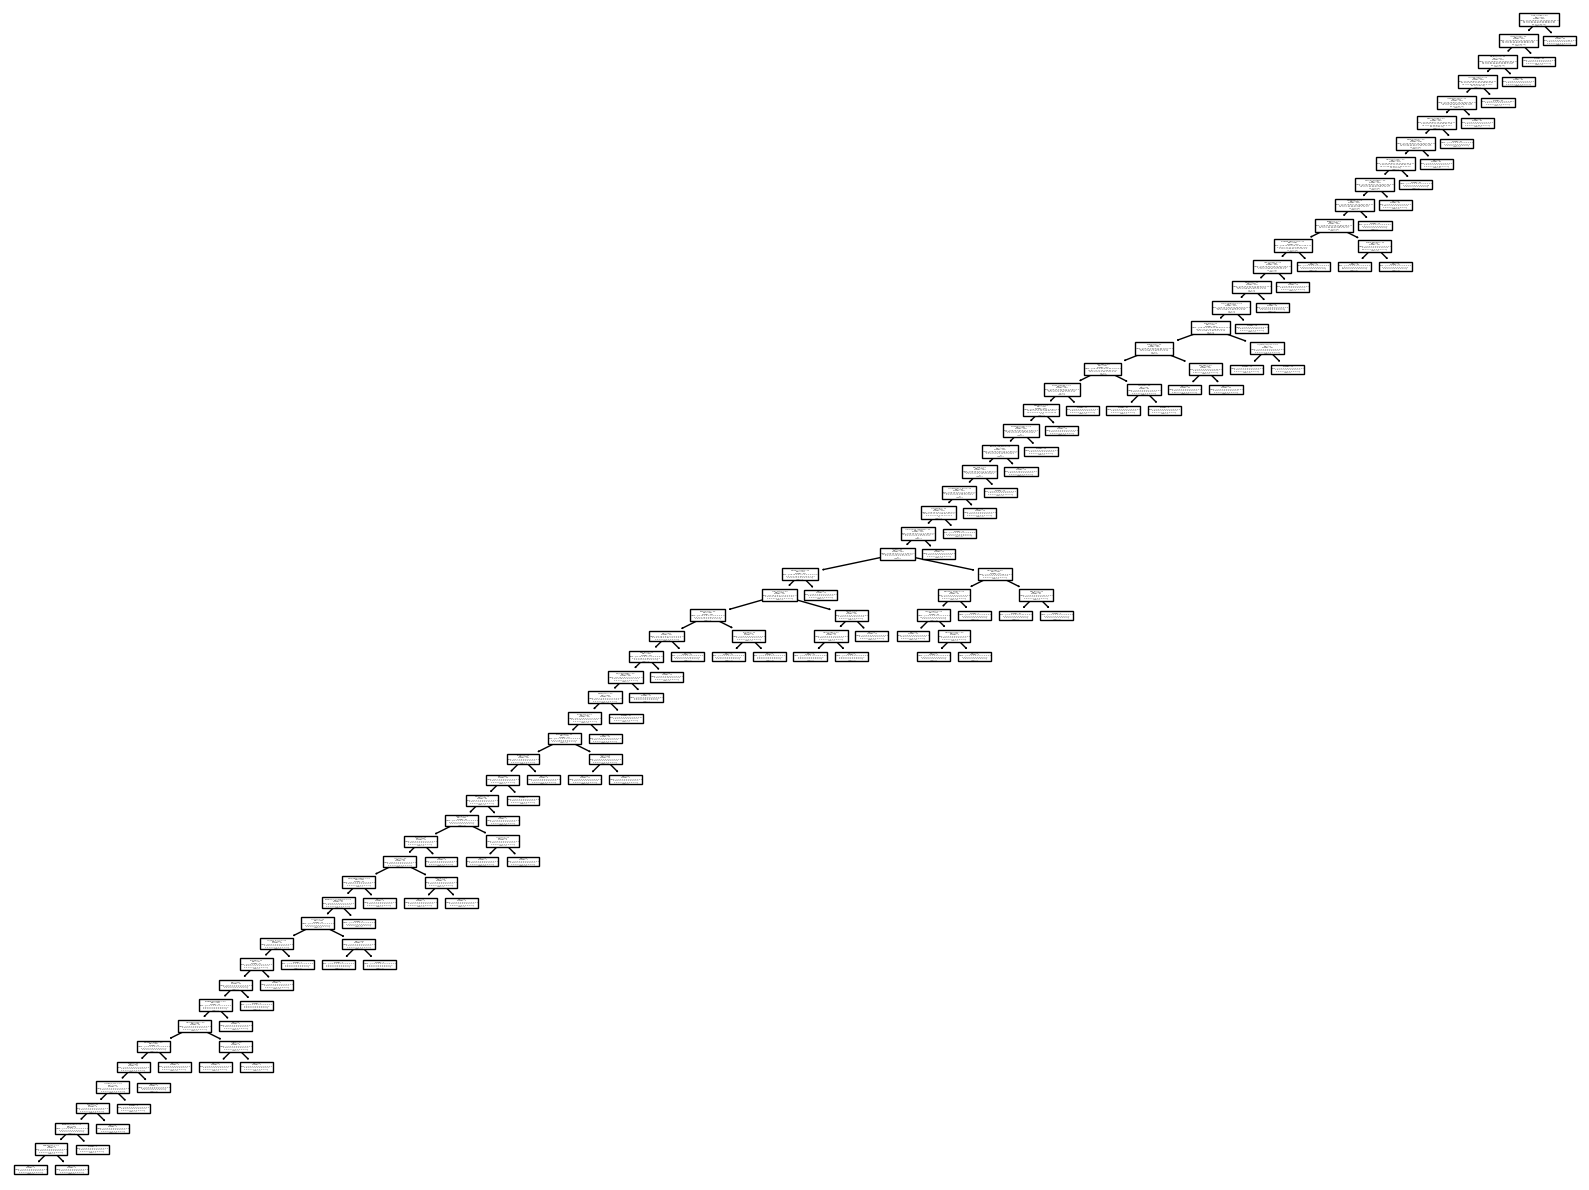

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Convert feature names and class names to lists of strings
feature_names = list(model.feature_names_in_)
class_names = list(map(str, model.classes_))

# Increase figure size
plt.figure(figsize=(16, 12))

# Plot the decision tree
plot_tree(model, feature_names=feature_names, class_names=class_names)

# Adjust spacing
plt.tight_layout()

# Save the plot as a high-resolution image file (e.g., PNG or PDF)
plt.savefig('decision_tree.png', dpi=900)

# Display a message indicating the successful save
print("Decision tree plot saved as decision_tree.png")
